# Redes Neuronales Artificiales: Trabajo Práctico 2


#### Integrantes:

- Maximiliano Dacko, LU  284/21
- María Marino, LU 450/21
- Giovanni Franco Gabriel Marraffini, LU 292/21

-----

### Descripción del conjunto de datos

El dataset consiste en documentos con descripciones de texto correspondientes a compañías brasileñas clasificadas en nueve categorías distintas. Los textos originales fueron preprocesados para obtener una *Bag-of-Words* de cada uno de ellos.

La primera columna representa la categoría a la cual pertenece la instancia. Las columnas subsiguientes representan, para cada palabra exceptuando preposiciones y artículos comunes, la frecuencia de dicha palabra en el texto original.

### Preliminares: importación de librerías, carga de datos y estandarización

Importamos las librerías necesarias:

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Descargamos los datos:

In [2]:
import requests
r = requests.get('https://git.exactas.uba.ar/redes-neuronales/clases/-/raw/master/practicas/datos/tp2_training_dataset.csv')
data = np.loadtxt(r.iter_lines(), delimiter = ',')

Separamos las categorías incluídas en el dataset (primera columna) del los *features* de cada instancia:

In [3]:
labels = [int(c) for c in data[:,0]]
data = data[:,1:]

data.shape

(900, 856)

El dataset contiene 900 instancias, con 856 _features_ cada una.

Estandarizamos los _features_ utilizando la fórmula

$$ \tilde{x} = \frac{x - \mu}{\sigma}$$

Donde $\tilde{x}$ es el valor estandarizado, $x$ es el valor original, $\mu$ es la media del dataset y $\sigma$ su desvío estándar.

In [4]:
data = (data - data.mean()) / data.std()

## Ejercicio 1: Reducción de dimensiones con Oja y Sanger

El objetivo en este ejercicio será reducir la alta dimensionalidad de las instancias a sólo nueve dimensiones. Para esto utilizaremos las reglas de aprendizaje de Oja y de Sanger.

### Función `dimReduction`

Creamos una función que nos permita rápidamente utilizar los algoritmos de Oja y Sanger.

Como **argumentos** recibe:
- `X`: el dataset de entrada
- `dimOutput`: la dimensión deseada de salida
- `method`: el método a utilizar (`Oja` ó `Sanger`)
- `eta`: el _learning rate_ a utilizar en el entrenamiento
- `epochs`: la cantidad de épocas en las que se va a entrenar el modelo
- `seed`: la semilla para utilizar en la incialización de la matriz de pesos (por default utilizamos como semilla 3)

Como **salida** devuelve la matriz de entrada mutiplicada por la matriz de pesos de la red entrenada. Esto equivale al sub-espacio de `dimOutput` dimensiones encontrado por el modelo. Lo implementamos de esta manera para poder, con el resultado, graficar el espacio resultante y verificar si es satisfactorio.

Adicionalmente, cada 100 épocas la función imprime una métrica de **ortogonalidad** de las dimensiones actuales:

$$ \text{Orthogonality} = \frac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{M} \left| \left( W^T \cdot W - I_M \right)_{ij} \right|$$

Donde $N$ es la cantidad de instancias del dataset, $M$ es la dimensión deseada de salida (o `dimOutput`) y $W$ es la matriz de pesos de tamaño $N$ por $M$.

Idealmente, esta métrica tiende a cero a medida que pasan las épocas, ya que esto indicaría que el modelo encontró un sub-espacio de menor dimensión en donde representar los datos preservando más información.


In [ ]:
def dimReduction(X: np.array, dimOutput: int, method: str, eta: float, epochs: int, seed: int = None):
    if seed: 
        rng = np.random.default_rng(seed) 
    else:
        rng = np.random
    I = X.shape[0]
    N = X.shape[1]
    W = rng.normal(loc = 0.0, scale = 0.5, size = (N, dimOutput))
    dW = np.zeros(W.shape)

    for _ in range(epochs):
        for i in range(I):
            Xi = X[i].reshape(1,N)
            Y = np.dot(Xi, W) 
            if method == 'Oja':
                Z = np.dot(Y, W.T)
                dW = np.outer(Xi - Z, Y)
            elif method == 'Sanger':
                D = np.triu(np.ones((dimOutput,dimOutput)))
                Z = np.dot(W, Y.T * D)
                dW = (Xi.T - Z) * Y
            else:
                raise ValueError(f'Unsupported value: {method}. Method must be one of (\'Oja\', \'Sanger\').')
        
            W += eta * dW
            
            # Usualmente la matriz de pesos se anula por un overflow en sus valores
            #  que resulta en operaciones aritméticas con +-inf
            if np.isnan(np.sum(W)): raise OverflowError(f'Overflow in weight matrix at epoch {_}')

        if (_ % 100 == 0 or _ == epochs - 1): print(f'Epoch {_} of {epochs}. \tOrthogonality: {np.sum(np.abs(np.dot(W.T, W) - np.identity(dimOutput) ))/2}')

    return X @ W

#### Función `plotDimReduction`

Creamos una función auxiliar para visualizar en tres dimensiones los resultados de la reducción de dimensionalidad.

In [ ]:
def plotDimReduction(Z: np.array, dimensions_to_plot: list[int], labels: list[int], elev: list[int] = [90, 0, 0], azim: list[int] = [-90, -90, 0]):
    if len(dimensions_to_plot) != 3:
        raise Exception('dimensions_to_plot must be a list of length three')
    else:
        A = dimensions_to_plot[0]
        B = dimensions_to_plot[1]
        C = dimensions_to_plot[2]


    fig = plt.figure(figsize = (30,20))

    # Primer plot, viewpoint standard
    ax = fig.add_subplot(1, 4, 1, projection='3d')
    ax.scatter3D(
        Z[:,A], 
        Z[:,B], 
        Z[:,C], 
        c = labels,
        cmap = 'tab10'
    )
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    ax.get_zaxis().set_ticklabels([])
    ax.set_xlabel(f'Dimensión {A}')
    ax.set_ylabel(f'Dimensión {B}')
    ax.set_zlabel(f'Dimensión {C}')

    # Segundo plot, viewpoint elev[0], azim[0]
    ax = fig.add_subplot(1, 4, 2, projection='3d')
    ax.scatter3D(
        Z[:,A], 
        Z[:,B], 
        Z[:,C], 
        c = labels,
        cmap = 'tab10'
    )
    ax.view_init(elev[0],azim[0])
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    ax.get_zaxis().set_ticklabels([])
    ax.set_xlabel(f'Dimensión {A}')
    ax.set_ylabel(f'Dimensión {B}')

    # Tercer plot, viewpoint elev[1], azim[1]
    ax = fig.add_subplot(1, 4, 3, projection='3d')
    ax.scatter3D(
        Z[:,A], 
        Z[:,B], 
        Z[:,C], 
        c = labels,
        cmap = 'tab10'
    )
    ax.view_init(elev[1],azim[1])
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    ax.get_zaxis().set_ticklabels([])
    ax.set_xlabel(f'Dimensión {A}')
    ax.set_zlabel(f'Dimensión {C}')

    # Cuarto plot, viewpoint elev[2], azim[2]
    ax = fig.add_subplot(1, 4, 4, projection='3d')
    ax.scatter3D(
        Z[:,A], 
        Z[:,B], 
        Z[:,C], 
        c = labels,
        cmap = 'tab10'
    )
    ax.view_init(elev[2], azim[2])
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    ax.get_zaxis().set_ticklabels([])
    ax.set_zlabel(f'Dimensión {C}')
    ax.set_ylabel(f'Dimensión {B}')

    plt.show()

### Entrenamiento con Oja

Tenemos dos hiperparámetros con los cuales experimentar. A priori pensamos que el *learning rate* será bajo ya que el entrenamiento en este tipo de algoritmos es incremental (es decir, se entrena de a una instancia por vez). Asimismo sabemos que no entrenaremos por más de 2500 *epochs* porque tomaría mucho tiempo.

En la etapa de experimentación previa al realizamiento de este trabajo pudimos observar que:

- Un *learning rate* mayor o igual a 0.01 causa un *overflow* en la matriz de pesos. Esto podría remediarse utilizando librerías como `BigFloat` pero decidimos no explorar ese camino.

In [ ]:
zOja = dimReduction(data, dimOutput = 9, method = 'Oja', eta = 0.01, epochs = 10, seed = 207)

OverflowError: Overflow in weight matrix at epoch 0

- *Learning rates* menores a 0.01 pero mayores a 0.0001 resultan en un estancamiento luego de una cierta cantidad de épocas.

In [ ]:
zOja1 = dimReduction(data, dimOutput = 9, method = 'Oja', eta = 0.0001, epochs = 500, seed = 207)

Epoch 0 of 500. 	Orthogonality: 29.891310741768514
Epoch 100 of 500. 	Orthogonality: 0.24008570012508504
Epoch 200 of 500. 	Orthogonality: 0.2617576590883168
Epoch 300 of 500. 	Orthogonality: 0.26550877975611
Epoch 400 of 500. 	Orthogonality: 0.25814179932884274
Epoch 499 of 500. 	Orthogonality: 0.2749391283709989


La variable `zOja1` almacena las novecientas instancias y sus correspondientes valores para las nueve dimensiones del sub-espacio encontrado por el modelo. Las graficaremos para intentar observar qué tanto se preservó la separación de las categorías originales. Cada punto representará una instancia, cada eje una dimensión de salida, y cada color una categoría de las provistas en el dataset original (*ground truth*).

Aún con el estancamiento podría pasar que el modelo reduzca exitosamente las dimensiones del dataset, pero vemos que no es así:

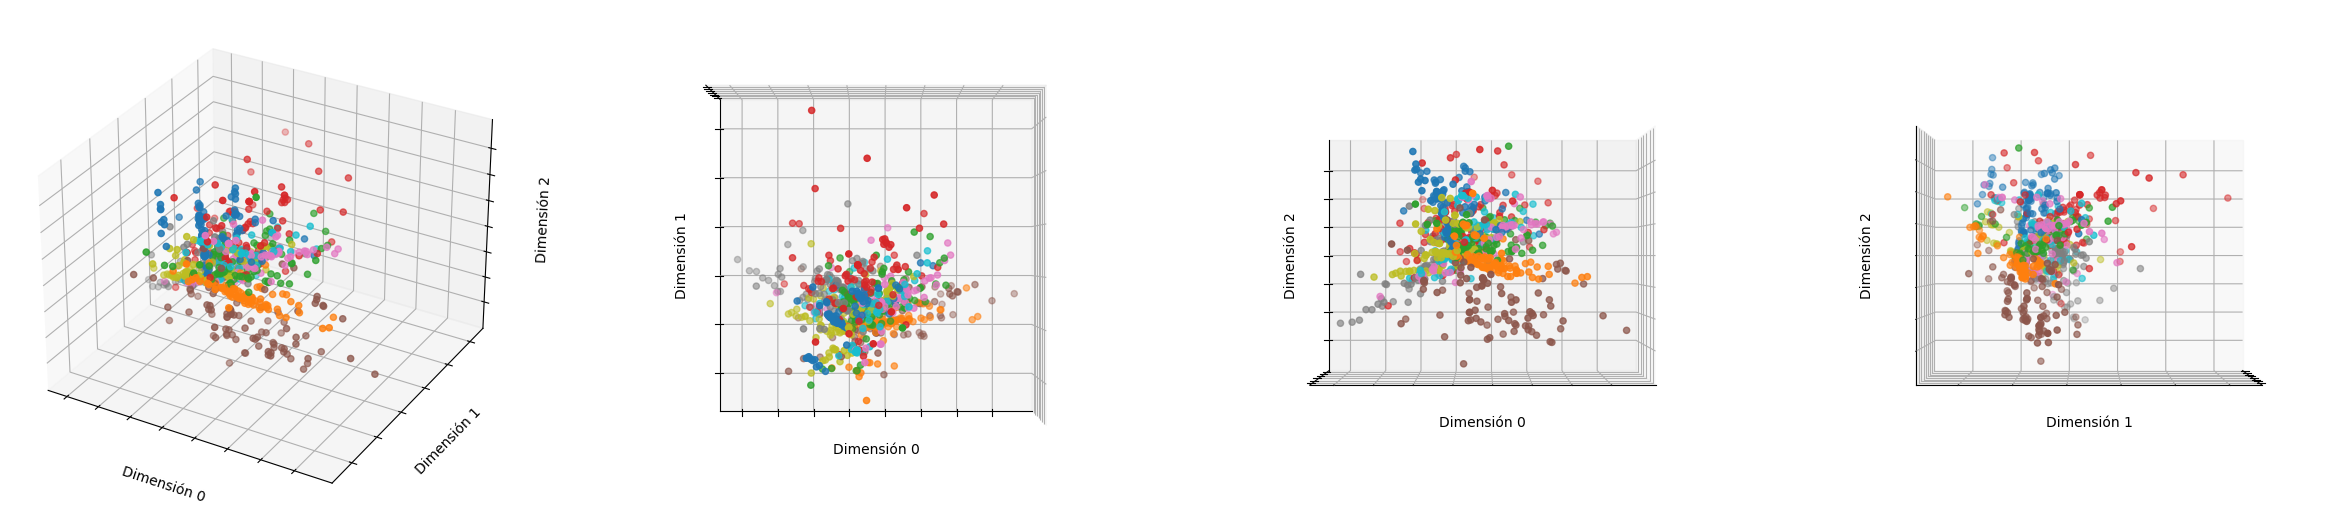

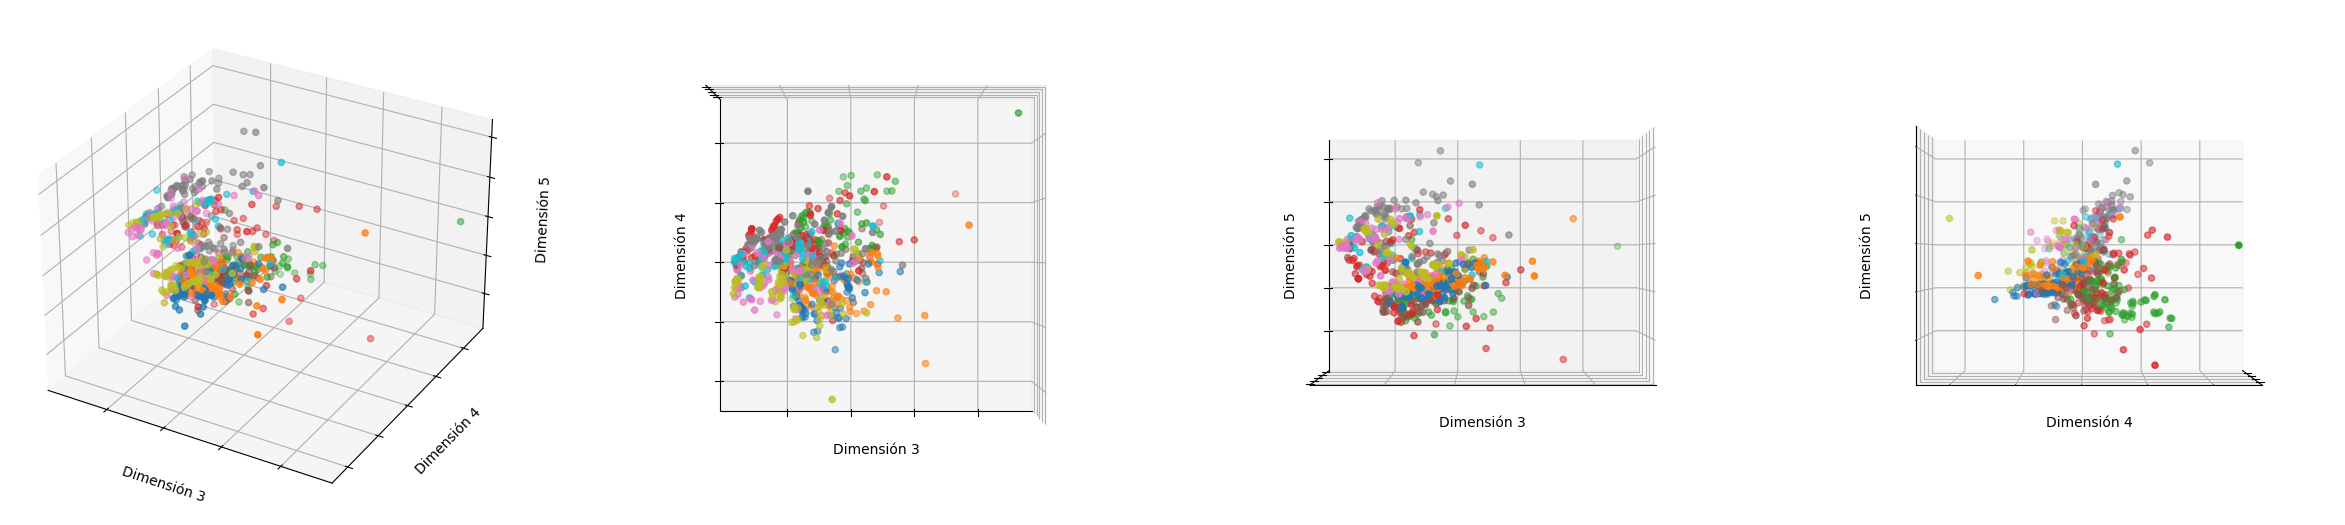

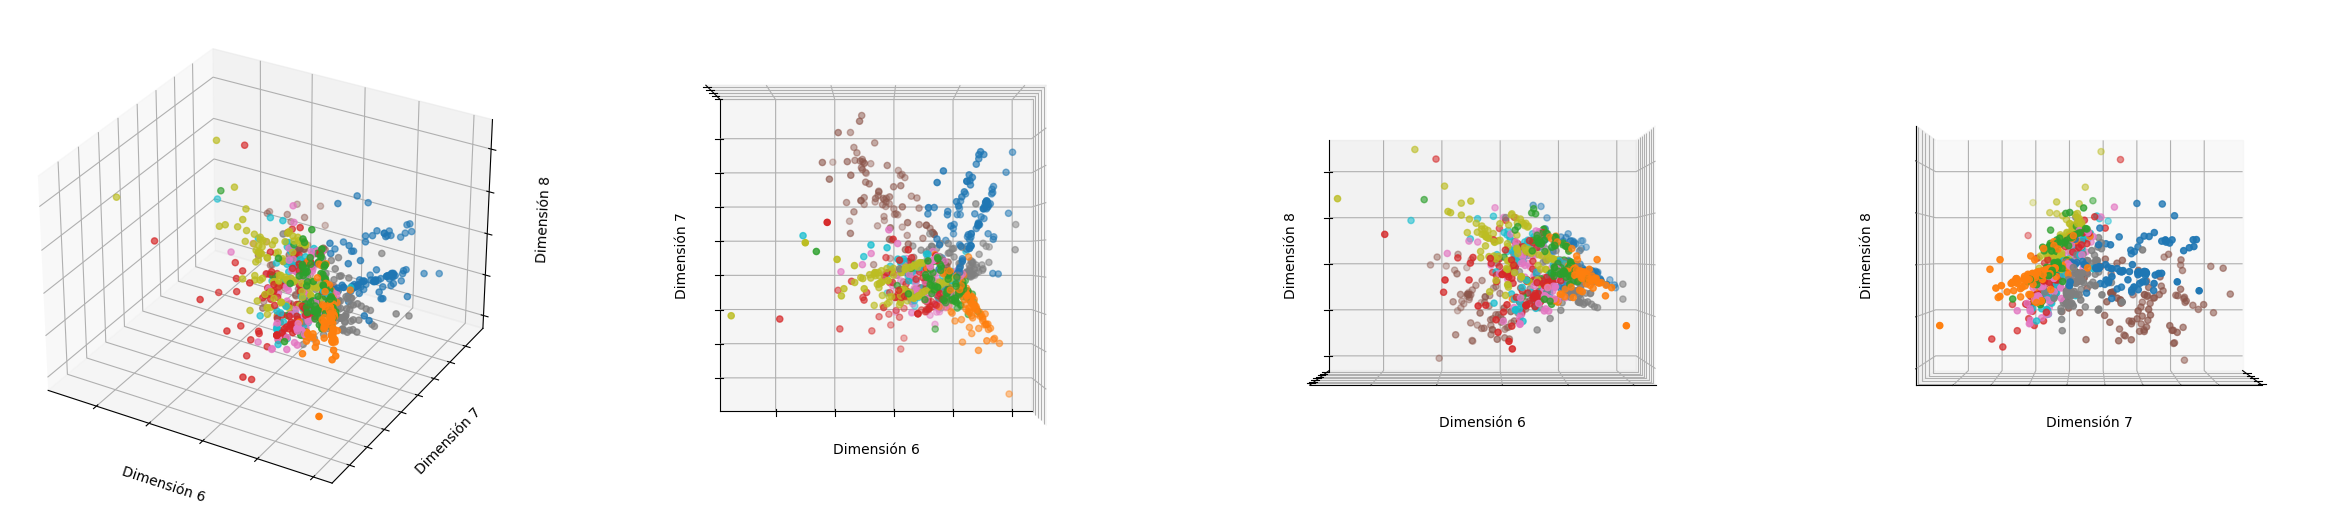

In [ ]:
plotDimReduction(zOja1, [0,1,2], labels=labels)
plotDimReduction(zOja1, [3,4,5], labels=labels)
plotDimReduction(zOja1, [6,7,8], labels=labels)

- Por último, luego de experimentar con distintos _learning rates_ llegamos a que valores menores a 0.00001 nos brindaban los mejores resultados, en particular:

In [ ]:
zOja2 = dimReduction(data, dimOutput = 9, method = 'Oja', eta = 0.000001, epochs = 1000, seed = 207)

Epoch 0 of 1000. 	Orthogonality: 938.96533328057
Epoch 100 of 1000. 	Orthogonality: 28.053397288142804
Epoch 200 of 1000. 	Orthogonality: 4.456440609417593
Epoch 300 of 1000. 	Orthogonality: 0.49760696056860243
Epoch 400 of 1000. 	Orthogonality: 0.04363925304405973
Epoch 500 of 1000. 	Orthogonality: 0.005424264173008711
Epoch 600 of 1000. 	Orthogonality: 0.0025373979669065347
Epoch 700 of 1000. 	Orthogonality: 0.0023751090390067035
Epoch 800 of 1000. 	Orthogonality: 0.002361508047500734
Epoch 900 of 1000. 	Orthogonality: 0.002355872248642294
Epoch 999 of 1000. 	Orthogonality: 0.002350661884627914


Si bien se estanca en las últimas ~300 épocas, los resultados son muy buenos ya que podemos ver a las nueve categorías bastante bien diferenciadas:

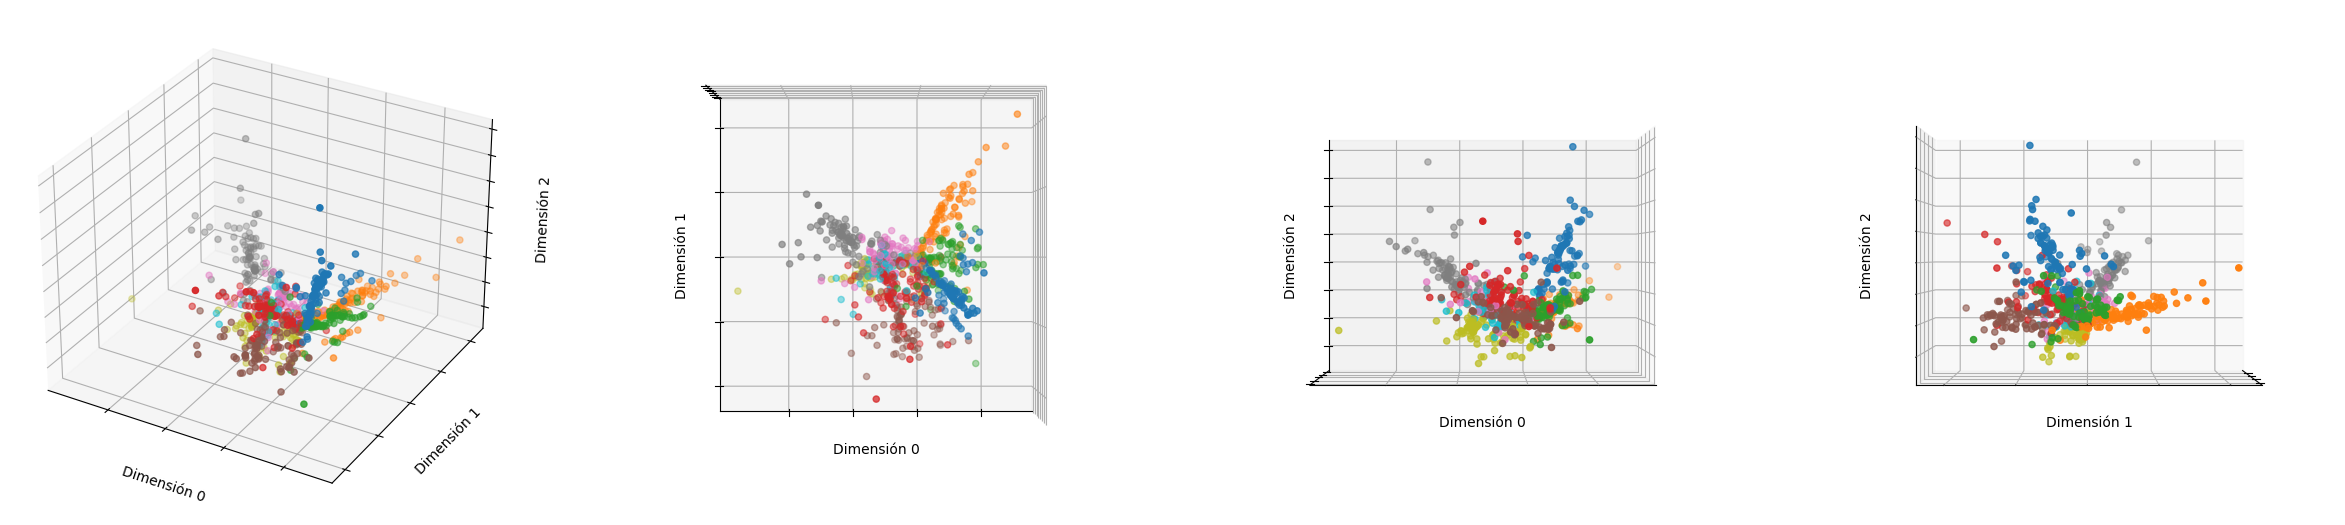

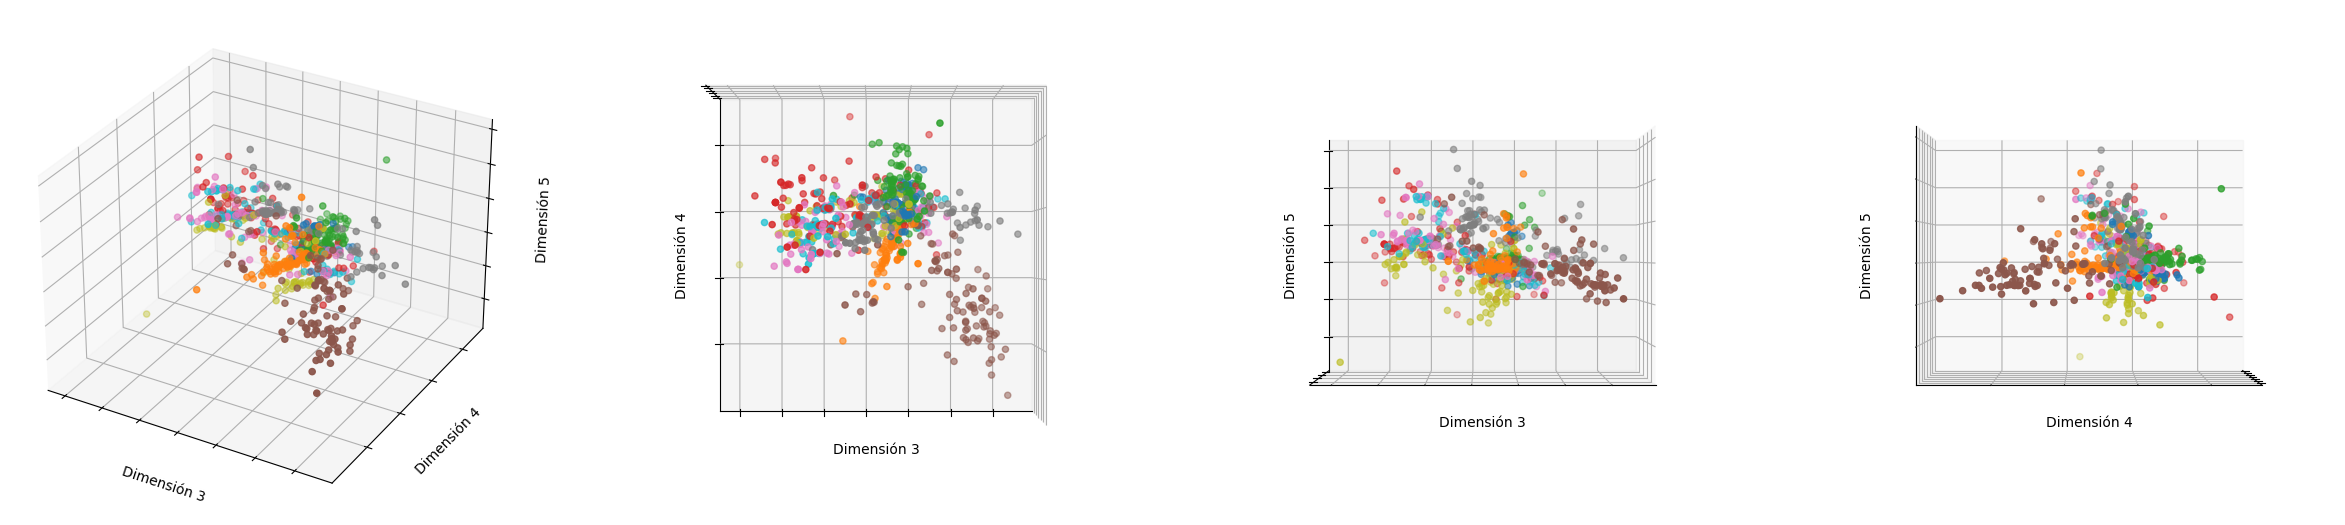

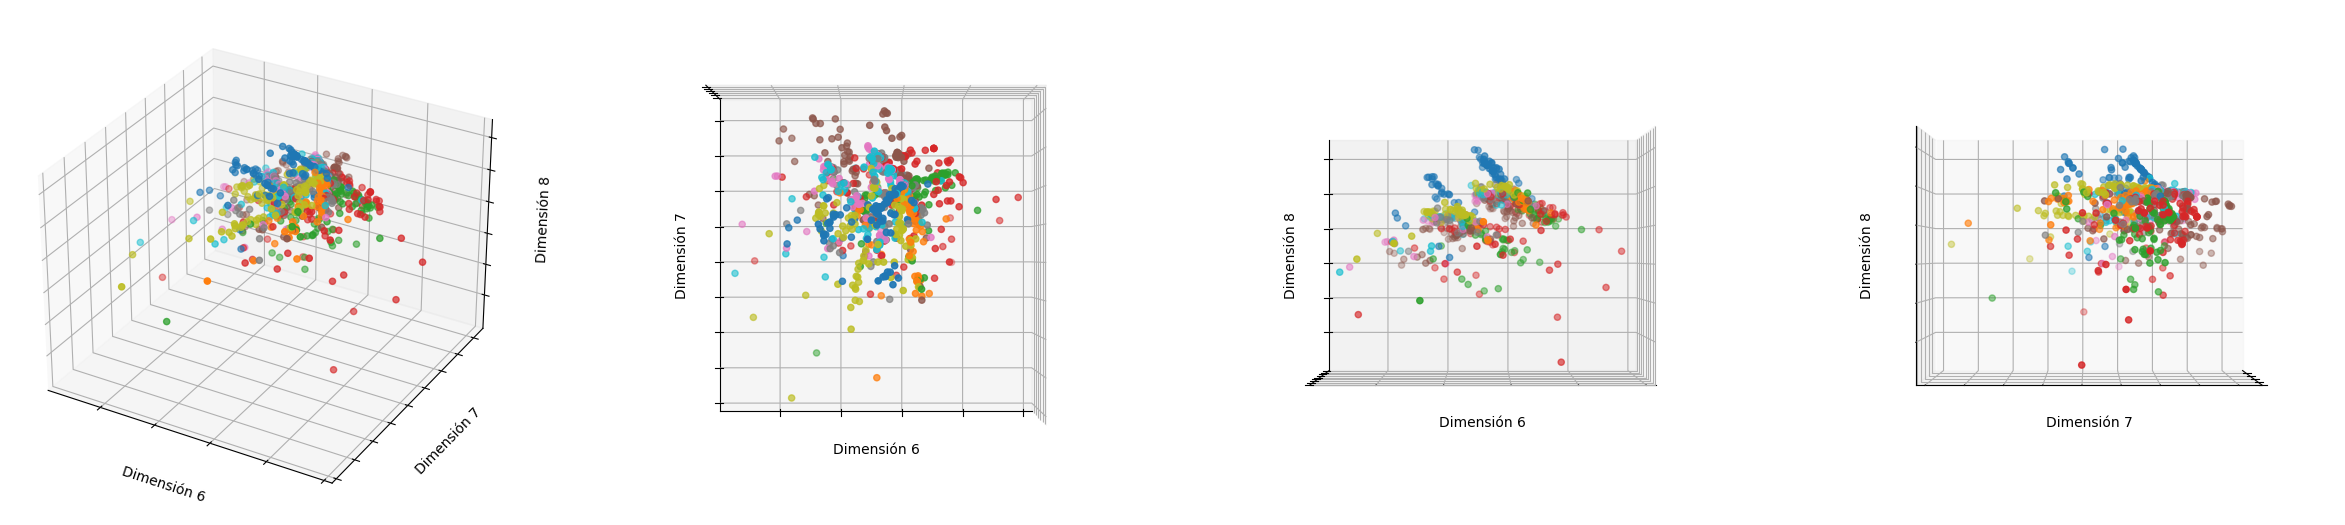

In [ ]:
plotDimReduction(zOja2, [0,1,2], labels=labels)
plotDimReduction(zOja2, [3,4,5], labels=labels)
plotDimReduction(zOja2, [6,7,8], labels=labels)

### Entrenamiento con Sanger

Para empezar probamos con los mismos hiperparámetros que nos dieron buenos resultados con el método de Oja:

In [ ]:
zSanger1 = dimReduction(data, dimOutput = 9, method = 'Sanger', eta = 0.000001, epochs = 1000, seed = 207)

Epoch 0 of 1000. 	Orthogonality: 850.5439014690534
Epoch 100 of 1000. 	Orthogonality: 10.113408305188052
Epoch 200 of 1000. 	Orthogonality: 2.517704980118589
Epoch 300 of 1000. 	Orthogonality: 2.018088030645106
Epoch 400 of 1000. 	Orthogonality: 1.3185423678553212
Epoch 500 of 1000. 	Orthogonality: 0.8840910579694858
Epoch 600 of 1000. 	Orthogonality: 0.5923455282628882
Epoch 700 of 1000. 	Orthogonality: 0.4265580462835688
Epoch 800 of 1000. 	Orthogonality: 0.31281241761343026
Epoch 900 of 1000. 	Orthogonality: 0.23303561917539112
Epoch 999 of 1000. 	Orthogonality: 0.1810526825077562


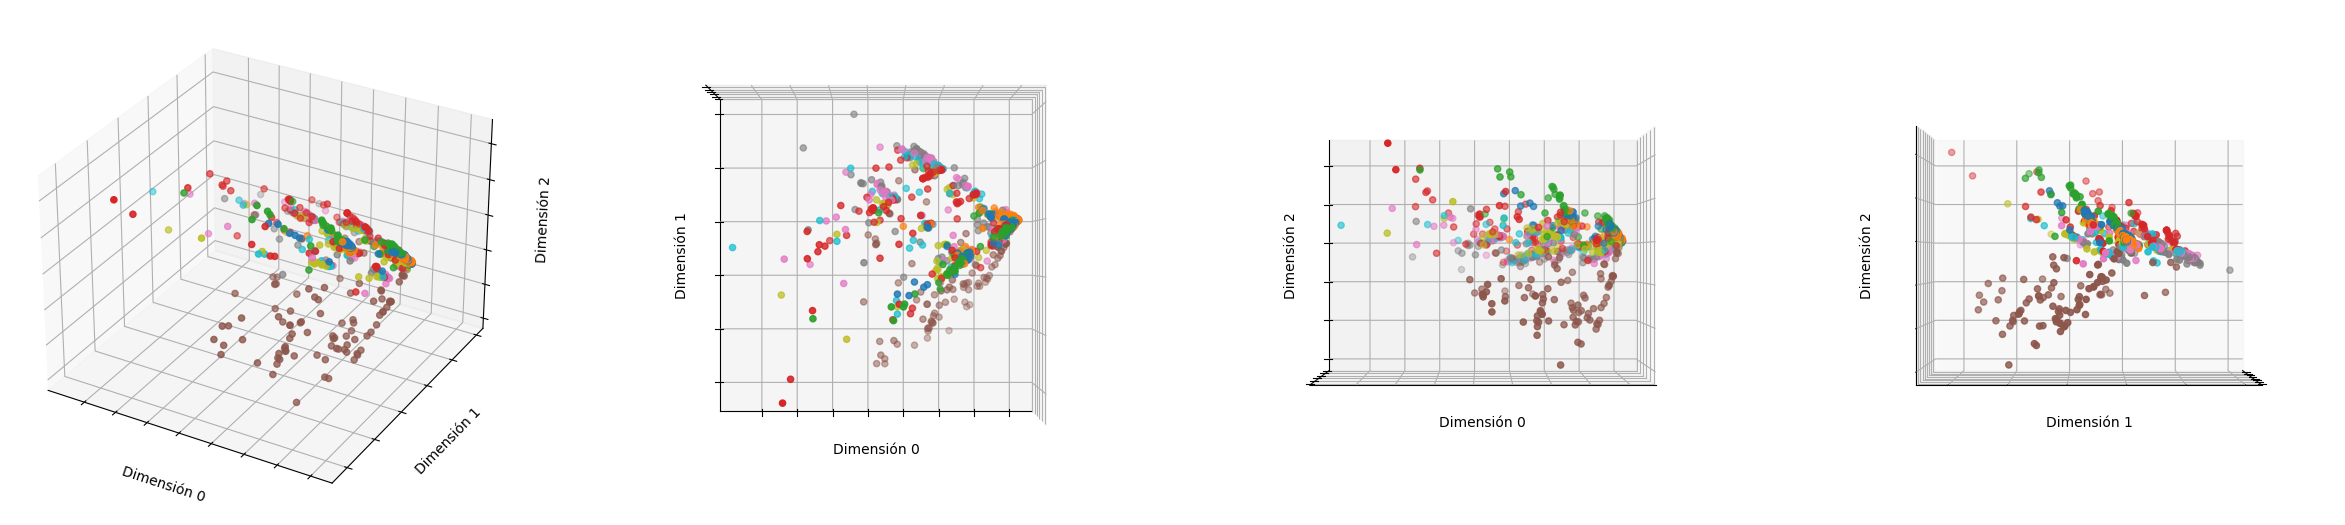

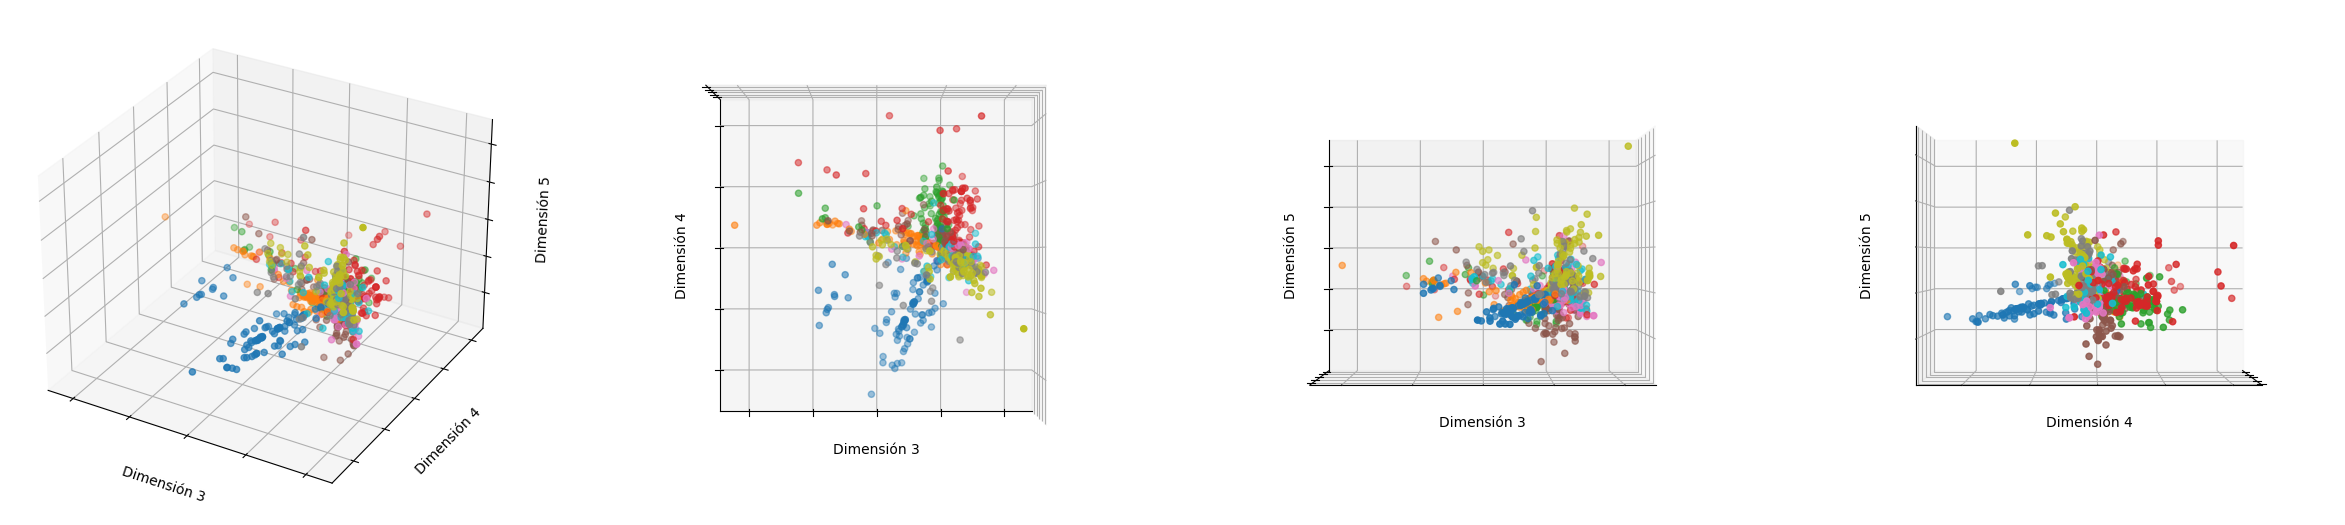

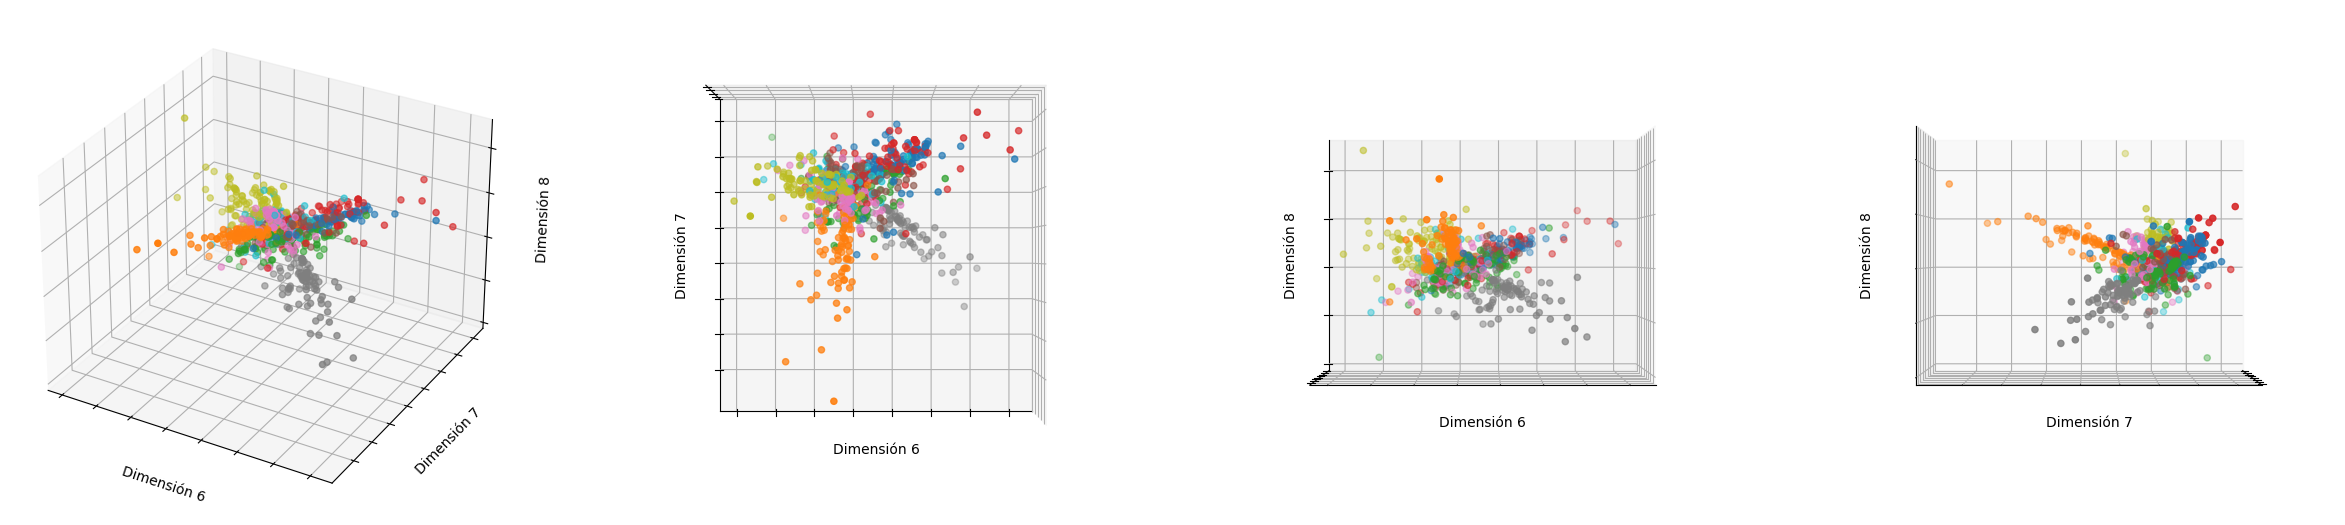

In [ ]:
plotDimReduction(zSanger1, [0,1,2], labels=labels)
plotDimReduction(zSanger1, [3,4,5], labels=labels)
plotDimReduction(zSanger1, [6,7,8], labels=labels)

Si bien estos resultados son buenos, quizás podemos conseguir algo mejor duplicando el *learning rate* para obetener mayor velocidad, y aumentando levente la cantidad de épocas:

In [ ]:
zSanger2 = dimReduction(data, dimOutput = 9, method = 'Sanger', eta = 0.000002, epochs = 1200, seed = 207)

Epoch 0 of 1200. 	Orthogonality: 711.622484000461
Epoch 100 of 1200. 	Orthogonality: 2.5220213113549232
Epoch 200 of 1200. 	Orthogonality: 1.3158668977475432
Epoch 300 of 1200. 	Orthogonality: 0.5996581609437888
Epoch 400 of 1200. 	Orthogonality: 0.32371814539008714
Epoch 500 of 1200. 	Orthogonality: 0.1929904928389658
Epoch 600 of 1200. 	Orthogonality: 0.13060538560960783
Epoch 700 of 1200. 	Orthogonality: 0.0944844495852851
Epoch 800 of 1200. 	Orthogonality: 0.07153974162741064
Epoch 900 of 1200. 	Orthogonality: 0.05738595901826874
Epoch 1000 of 1200. 	Orthogonality: 0.048425666531204004
Epoch 1100 of 1200. 	Orthogonality: 0.042754897041653396
Epoch 1199 of 1200. 	Orthogonality: 0.038777326763751056


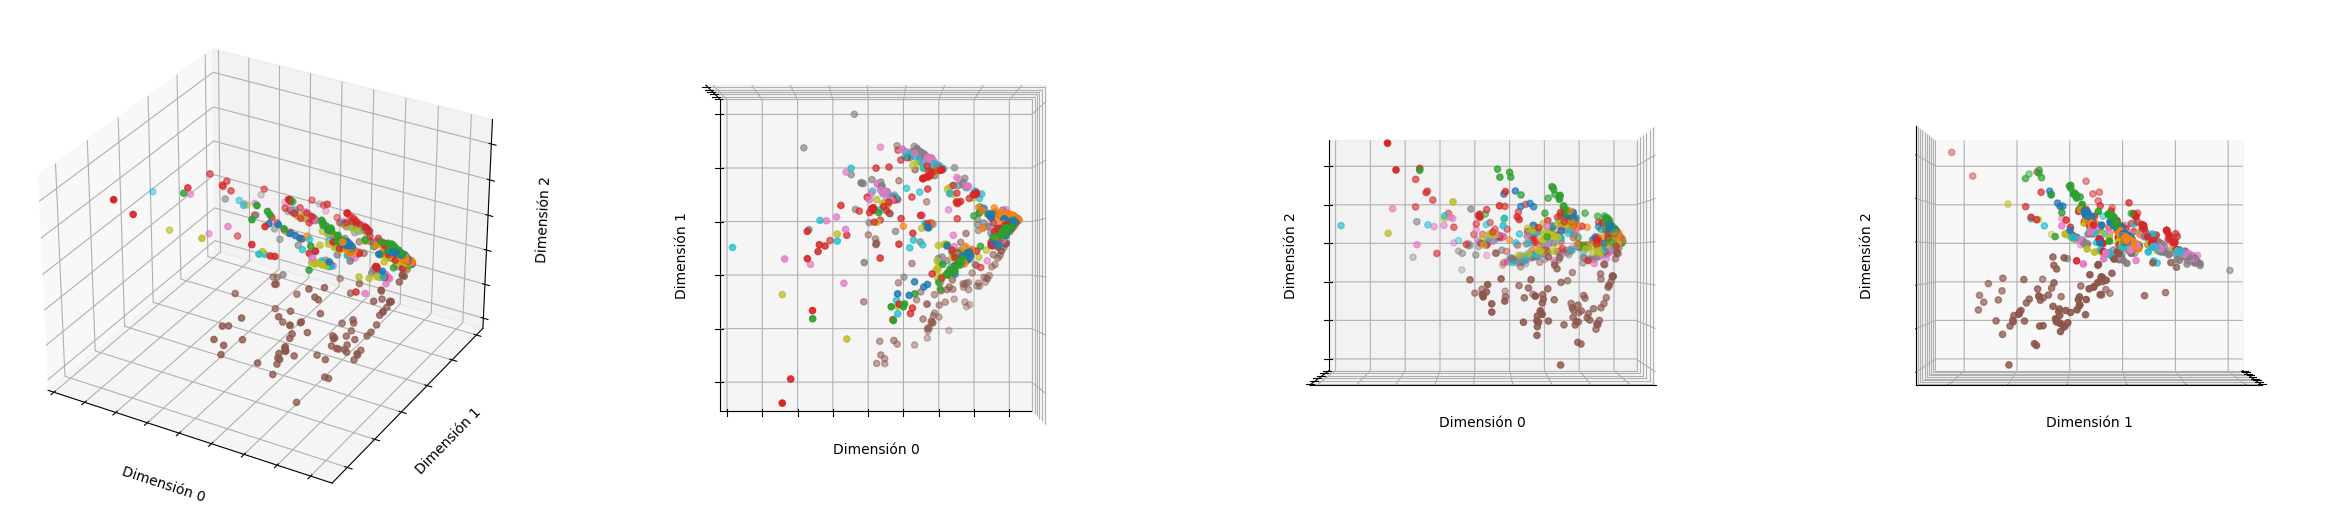

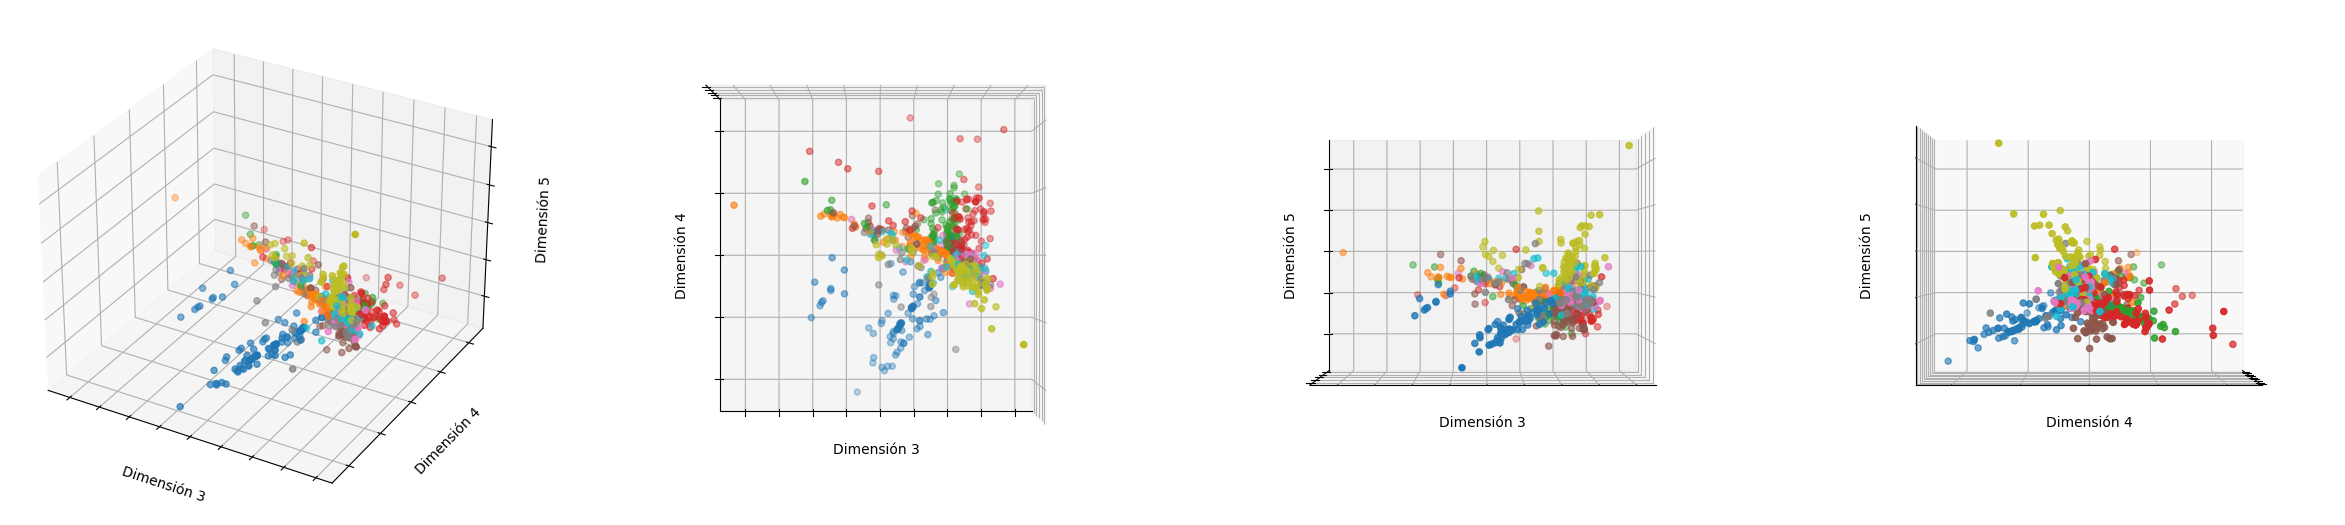

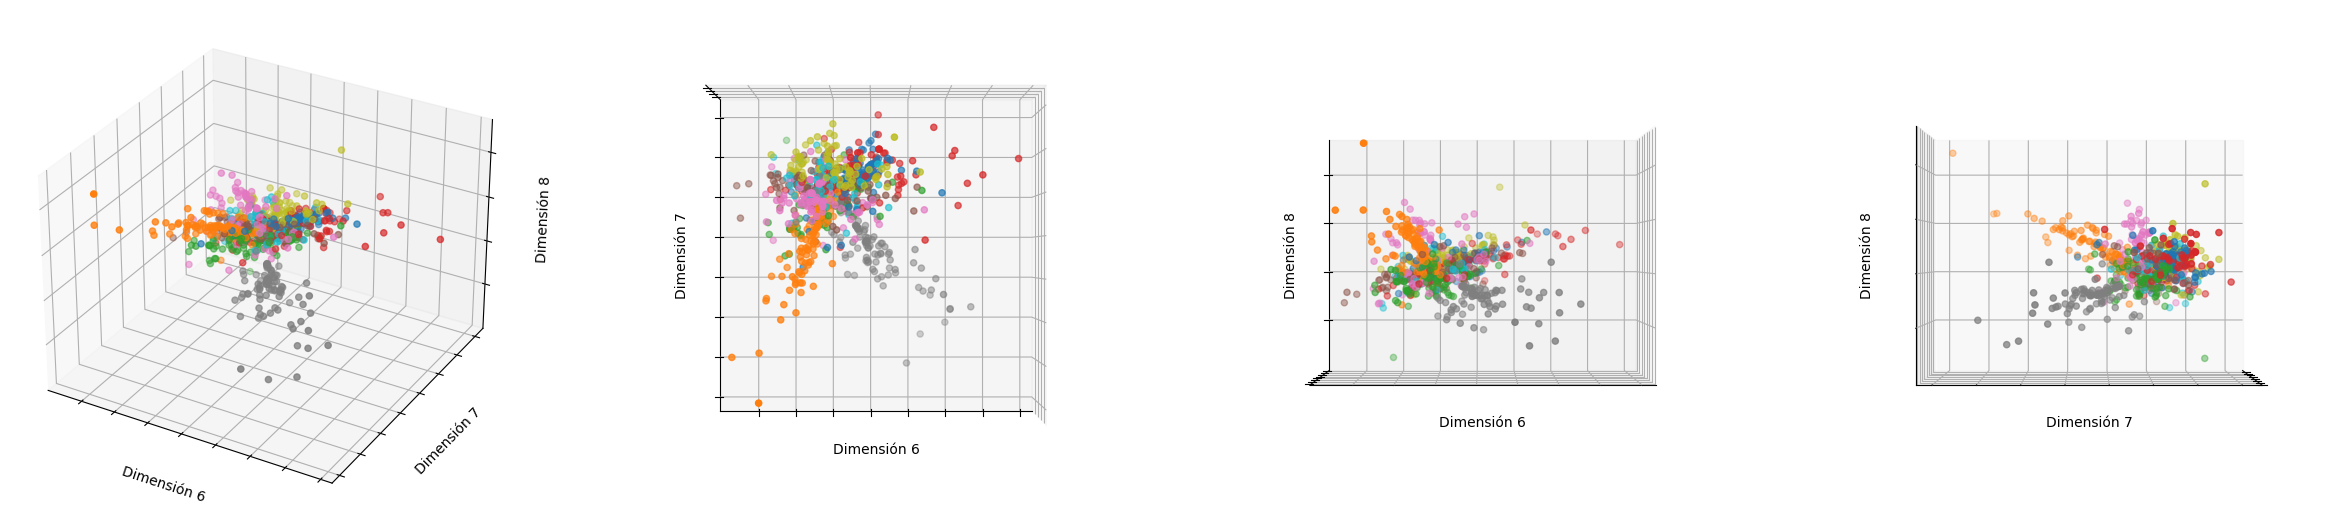

In [ ]:
plotDimReduction(zSanger2, [0,1,2], labels=labels)
plotDimReduction(zSanger2, [3,4,5], labels=labels)
plotDimReduction(zSanger2, [6,7,8], labels=labels)

Estos resultados presentan cierta mejora en la distinción de las categorías originales, como se puede apreciar en las figuras que se ven arriba y en la comparación de las métricas de ortogonalidad.

## Ejercicio 2: Mapas auto-organizados

Para este problema decidimos utilzar mapas de Kohonen. Para ello creamos una nueva clase llamada `SOM`. La misma consta de tres métodos:

- `train` toma el conjunto de datos de entrenamiento y los hiperparámetros para entrenar el modelo. Es posible especificar funciones particulares para el decaimiento del *learning rate* e *influence rate*.
- `best_matching_unit` toma una instancia particular y devuelve la unidad que se activa para esa instancia, según el estado actual de la matriz de pesos.
- `plotScatter` toma un conjunto de datos y sus categorías y los grafica en un scatter plot. Utilizamos este tipo de gráfico ya que nos permite ver al mismo tiempo la distribución de las instancias en las unidades de salida tanto en cantidad como en categoría.


In [93]:
class SOM:
    def __init__(self, featureCount, mapSize, seed = 3):
        self.rng = np.random.default_rng(seed)
        self.N = featureCount
        self.mapSize = mapSize
        self.coord_map = np.array([[(i,j) for j in range(self.mapSize)] for i in range(self.mapSize)])
        self.W = self.rng.normal(0, 1, (self.mapSize, self.mapSize, self.N))


    def best_matching_unit(self, x):
        e = x - self.W
        n = np.linalg.norm(e, axis = 2)
        bmu = np.unravel_index(np.argmin(n), n.shape)

        return bmu
    
    def train(self, X: np.array, lr_start: float, lr_decay: float, ir_start: float, ir_decay: float, epochs: int, lr_function_decay = lambda x: x, ir_function_decay = lambda x: x):
        I = X.shape[0]
        for epoch in range(epochs):
            for i in range(I):
                
                x = X[i].reshape(1, self.N)
                e = x - self.W
                bmu = self.best_matching_unit(x)

                d = np.linalg.norm(self.coord_map - bmu, axis = 2)

                lr = lr_start * np.exp(- lr_function_decay(epoch) * lr_decay)
                ir = ir_start * np.exp(- ir_function_decay(epoch) * ir_decay)
                pf = np.exp(-d / (2 * np.square(ir))).reshape((self.mapSize, self.mapSize, 1))
                dW = lr * pf * e
                self.W += dW

            if epoch % 100 == 0: print(f'Epoch {epoch} of {epochs}')

    def plotScatter(self, X: np.array, labels: list[int]):
        I = X.shape[0]

        bmu_x = []
        bmu_y = []
        for i in range(I):
            x = X[i].reshape(1, self.N)
            bmu = self.best_matching_unit(x)
            bmu_x.append(bmu[0]) 
            bmu_y.append(bmu[1]) 

        # Grafico cada instancia como un punto dentro de la unidad de salida correspondiente, agrego una distribución normal para no tener todos los puntos en el centro de la unidad
        plt.scatter(bmu_x + np.random.normal(0, 0.15, I), bmu_y + np.random.normal(0, 0.15, I), c = labels, cmap = 'tab10', alpha = 0.5)
        plt.title("Mapa auto-organizado")
        plt.show()

### Selección de hiperparámetros

Para obtener el mapa deseado, fue necesario explorar diferentes modelos hasta encontrar los hiperparámetros correctos.

Para ello optamos primero por analizar la velocidad de entrenamiento del modelo y decidimos que aproximadamente **1000 épocas** de aprendizaje eran suficientes y no tardaban demasiado (esto depende de las unidades de salida del mapa: a mayor cantidad de unidades de salida, mayor es el tiempo transcurrido). 

Luego, al fijar este valor pudimos empezar a buscar *learning rates* e *influence rates*. Buscamos distintas combinaciones de valores iniciales y *decays* tales que el decaimiento fuera exponencial pero llegara a ser indistinguible recién despues de que las 1000 épocas transcurrieran, tal como se muestra en el siguiente gráfico:

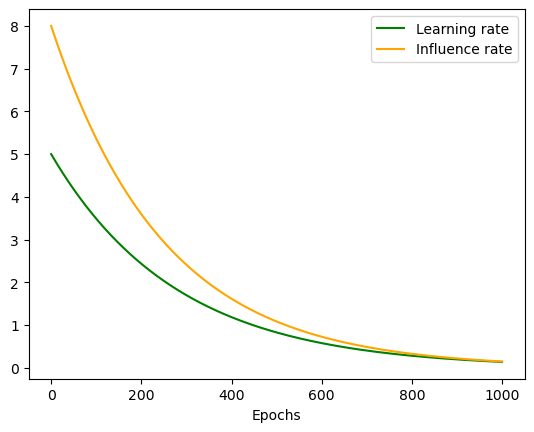

In [17]:
i = np.linspace(0, 1000, 1000) # El eje x representa las épocas, 1000 valores desde 0 a 1000
ir_st = 8 # Influence rate start
ir_dr = 0.004 # Influence rate decay
lr_st = 5 # Learning rate start
lr_dr = 0.0036 # Learning rate decay
lr = lambda x: lr_st * np.exp(-x * lr_dr)
ir = lambda x: ir_st * np.exp(-x * ir_dr)

plt.plot(i, lr(i), color = 'green')
plt.plot(i, ir(i), color = 'orange')
plt.legend(['Learning rate', 'Influence rate'])
plt.xlabel('Epochs')
plt.show()

Adicionalmente, 

- respecto al **radio de influencia inicial** pensamos que debería ser lo suficientemente grande como para asegurar que la primera unidad ganadora alcance con su influencia a todo el mapa, evitando así que queden secciones del mapa sin activar.
- En cuanto al **tamaño del mapa**, buscamos que la cantidad de unidades de salida nos permita tener una cantidad significativa de datos en cada una pero que, al mismo tiempo, sea suficiente como para que no haya exacatamente una clase por unidad de salida (pues esto sería bueno únicamente en un escenario donde realmente todas las clases sean linealmente separables o no haya ningún tipo de "frontera" entre clases). Por esto probamos de 4x4, 5x5 y 6x6.

Para tamaño 5x5, unos hiperparámetros que nos parecieron funcionar bien fueron los siguientes (dejamos una seed particular pero estos hiperparámtros funcionan más o menos bien en general, para probar recomendamos cambiar la seed y volver a correr esta celda y la siguiente para comparar resultados).

In [96]:
model1 = SOM(featureCount = data.shape[1], mapSize = 5, seed = 207)

model1.train(
    X = data,
    lr_start = 2,
    lr_decay = 0.005,
    ir_start = 8,
    ir_decay = 0.004,
    epochs = 1000
)


Epoch 0 of 1000
Epoch 100 of 1000
Epoch 200 of 1000
Epoch 300 of 1000
Epoch 400 of 1000
Epoch 500 of 1000
Epoch 600 of 1000
Epoch 700 of 1000
Epoch 800 of 1000
Epoch 900 of 1000



Con estos hiperparámetros el mapa nos queda así:

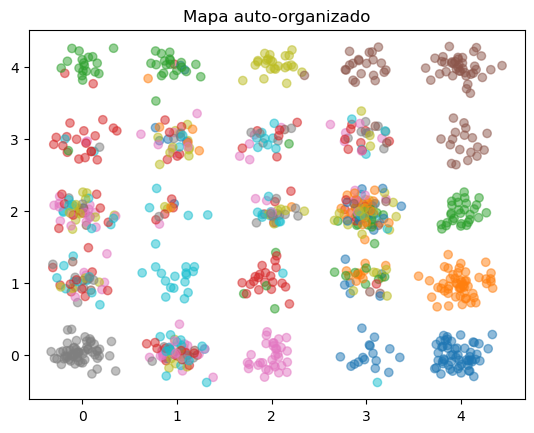

In [97]:
model1.plotScatter(data, labels)

Para 4x4 los hiperaprámetros que nos parecieron correctos fueron:

In [98]:
model2 = SOM(featureCount = data.shape[1], mapSize = 4, seed = 207)

model2.train(
    X = data,
    lr_start = 2,
    lr_decay = 0.004,
    ir_start = 7,
    ir_decay = 0.004,
    epochs = 1000
)

Epoch 0 of 1000
Epoch 100 of 1000
Epoch 200 of 1000
Epoch 300 of 1000
Epoch 400 of 1000
Epoch 500 of 1000
Epoch 600 of 1000
Epoch 700 of 1000
Epoch 800 of 1000
Epoch 900 of 1000


Y el mapa correspondiente es el siguiente:

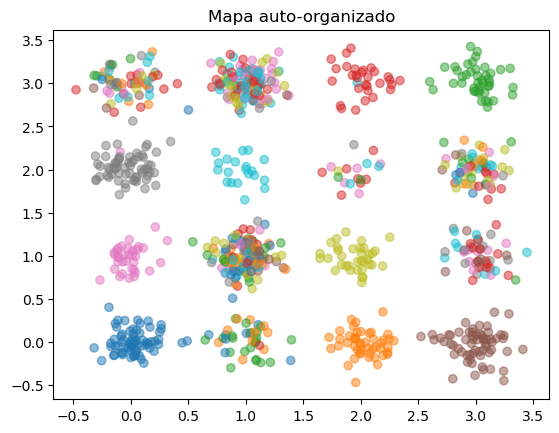

In [99]:
model2.plotScatter(data, labels)

Para 6x6

Epoch 0 of 1000
Epoch 100 of 1000
Epoch 200 of 1000
Epoch 300 of 1000
Epoch 400 of 1000
Epoch 500 of 1000
Epoch 600 of 1000
Epoch 700 of 1000
Epoch 800 of 1000
Epoch 900 of 1000


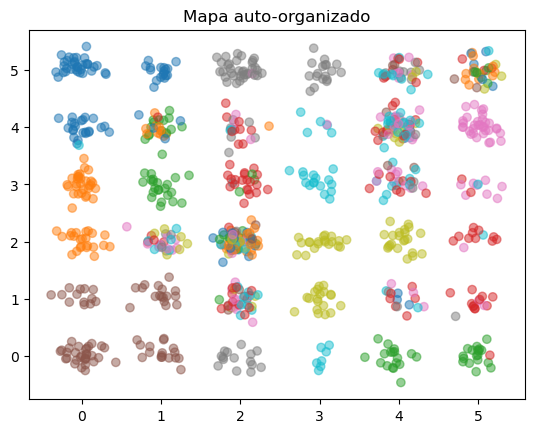

In [100]:
model3 = SOM(featureCount = data.shape[1], mapSize = 6, seed = 207)

model3.train(
    X = data,
    lr_start = 2,
    lr_decay = 0.004,
    ir_start = 7,
    ir_decay = 0.004,
    epochs = 1000
)

model3.plotScatter(data, labels)

#### Función de costo

No satisfechos con esta búsqueda "a ojo" de los hiperparámetros, decidimos medir lo que considerabamos que era el error en un mapa cuando veíamos los resultados para así luego automatizar la busqueda, recorriendo el espacio de los hiperparámetros y quedándonos con la tupla de aquellos que minimizara el error.

Para esto asumimos que un mapa tiene mucho error cuando quedan unidades de salida sin ser activadas. Para medir esto entonces utilizamos una medida similar al error cuadrático medio. Si llamamos $N$ a la cantidad de datos, $M^2$ a la cantidad de unidades en el mapa y $X_i$ a la cantidad de instancias que efectivamente se activaron en la unidad de salida $i$:

$$\sum_{i = 0}^{M^2} \Big(\frac{N}{M^2} - X_i\Big)^2$$

Por otro lado, queremos ver además que dentro de cada unidad de salida la "entropía" sea lo más pequeña posible, es decir, nos gustaría penalizar a una unidad de salida cuando tiene por ejemplo la mitad de sus instancias de una categoria y la mitad de otra. Aún más si tiene por ejemplo un tercio de tres categorías distintas. Pero si son todas de una misma categoria o si no hay ningúna de una categoría en particular entonces queremos que este error sea 0.
Para ello se hace una doble sumatoria, la primera corresponde a las unidades de salida y la segunda recorre todas las categorías para cada unidad. Lo que hicimos en definitiva es sacar la proporción de cada categoría que hay en cada unidad $i$ y a esa proporción le aplicamos la función $f(x) = -4 x^2 + 4x $ que vale 0 en $x=0$ y en $x = 1$ pero vale 1 en $x=0.5$. De esta manera, una proporción muy grande o muy chica (y las demás en 0) queda poco penalizada pero una proporción más o menos uniforme para todas las categorías tendría mucho error.

Respecto al primer término, este parece no importar pues es de una magnitud significativamente menor. Para balancear esto decidimos multiplicarlo por un escalar que lo lleve a un orden de magnitud semejante al primer término. Dicho escalar es $\frac{N}{M^2}$. 

Llamamos $C$ a la cantidad de categorías, $P_{ij}$ a la proporción de la categoría $j$ en la unidad de salida $i$. En definitiva el error total quedaría calculado de la siguiente manera: 

$$\sum_{i=1}^{M^2} \Big[ \big(\frac{N}{M^2} - X_{i}\big)^2 + \frac{N}{M^2} \sum_{j=1}^{C}\big(-4P_{ij}^2 + 4P_{ij} \big) \Big]  $$

In [102]:
def costo(X, ir_st, ir_dr, lr_st, lr_dr):

    model = SOM(featureCount = data.shape[1], mapSize = 6, seed = 207)

    model.train(
        X = data,
        lr_start = lr_st,
        lr_decay = lr_dr,
        ir_start = ir_st,
        ir_decay = ir_dr,
        epochs = 500
    )

    I = X.shape[0]
    N = X.shape[1]

    bmu_x = []
    bmu_y = []
    for i in range(I):
        x = X[i].reshape(1, N)
        bmu = model.best_matching_unit(x)
        bmu_x.append(bmu[0]) 
        bmu_y.append(bmu[1])

    bmus = np.stack(bmu_x, bmu_y, axis=1)

    aux = np.zeros((model.mapSize, model.mapSize, 10))

    for i in range(len(m[0])):
        aux[bmus[0,i], bmus[1,i], 0] += 1
        aux[bmus[0,i], bmus[1,i], labels[i]] += 1

    M2 = model.mapSize**2
    costo_total = 0
    for i in range(model.mapSize):
        print("costo:", costo_total)
        for j in range(model.mapSize):
            costo_total+= int((900/(M2) - aux[i,j,0])**2)
            for k in range(1,10):
                if aux[i,j,0] != 0:
                    costo_total+= int((900/(M2))* (-4*(aux[i,j,k]/aux[i,j,0] )**2  + 4*(aux[i,j,k] / aux[i,j,0])))
                else:
                    costo_total+= int((900/(M2))* 1000)
    return costo_total

Utilizando esta función de costo, se pudo iterar sobre una grilla en el espacio de los hiperparámetros para buscar los que menor costo dieran sobre este espacio (esta parte del código no la agregamos porque tardó mas de 14 horas en correr en otra máquina mientras seguíamos probando a mano nuevos hiperparámetros ). Los hiperparámetros que se encontraron que minimizaban dicha función se muestran a continuación

Para 4x4

Epoch 0 of 1000
Epoch 100 of 1000
Epoch 200 of 1000
Epoch 300 of 1000
Epoch 400 of 1000
Epoch 500 of 1000
Epoch 600 of 1000
Epoch 700 of 1000
Epoch 800 of 1000
Epoch 900 of 1000


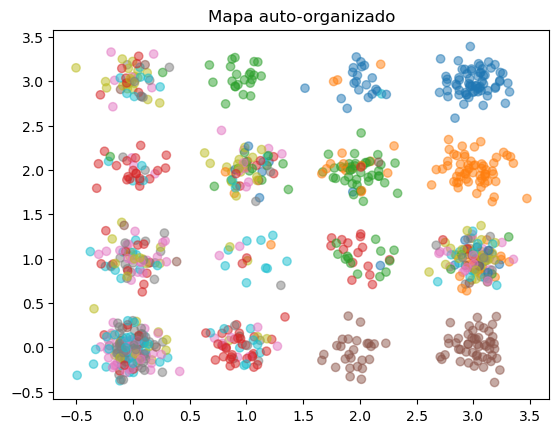

In [103]:
model4 = SOM(featureCount = data.shape[1], mapSize = 4, seed = 207)

model4.train(
    X = data,
    lr_start = 0.031,
    lr_decay = 0.003649098584102092,
    ir_start = 1,
    ir_decay = 0.0013862943611198907,
    epochs = 1000
)

model4.plotScatter(data, labels)

Epoch 0 of 1000
Epoch 100 of 1000
Epoch 200 of 1000
Epoch 300 of 1000
Epoch 400 of 1000
Epoch 500 of 1000
Epoch 600 of 1000
Epoch 700 of 1000
Epoch 800 of 1000
Epoch 900 of 1000


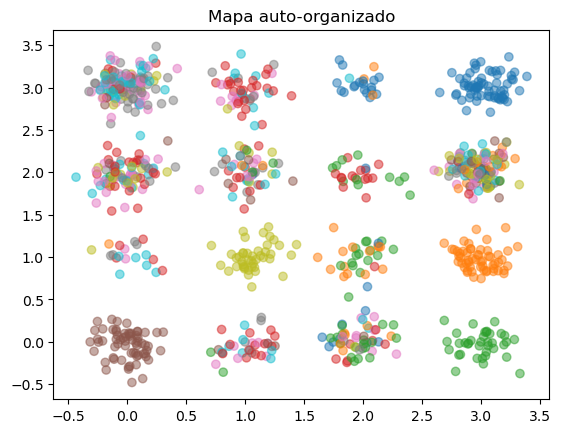

In [104]:
model5 = SOM(featureCount = data.shape[1], mapSize = 4, seed = 207)

model5.train(
    X = data,
    lr_start = 0.8000000000000003,
    lr_decay = 0.010150347630467654,
    ir_start = 2,
    ir_decay = 0.0027725887222397813,
    epochs = 1000
)

model5.plotScatter(data, labels)

Para 5x5

Epoch 0 of 1000
Epoch 100 of 1000
Epoch 200 of 1000
Epoch 300 of 1000
Epoch 400 of 1000
Epoch 500 of 1000
Epoch 600 of 1000
Epoch 700 of 1000
Epoch 800 of 1000
Epoch 900 of 1000


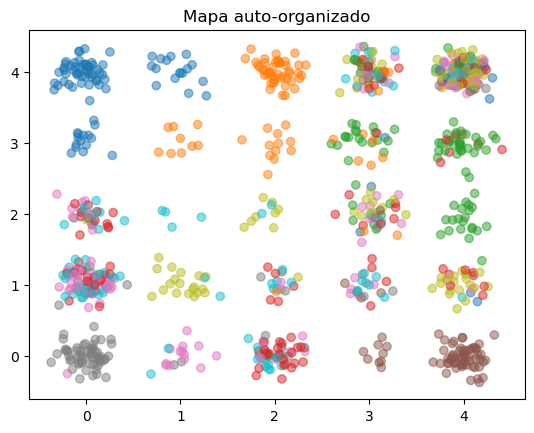

In [105]:
model6 = SOM(featureCount = data.shape[1], mapSize = 5, seed = 207)

model6.train(
    X = data,
    lr_start = 0.9800000000000004,
    lr_decay = 0.010556229318461036,
    ir_start = 2,
    ir_decay = 0.0027725887222397813,
    epochs = 1000
)

model6.plotScatter(data, labels)

Epoch 0 of 1000
Epoch 100 of 1000
Epoch 200 of 1000
Epoch 300 of 1000
Epoch 400 of 1000
Epoch 500 of 1000
Epoch 600 of 1000
Epoch 700 of 1000
Epoch 800 of 1000
Epoch 900 of 1000


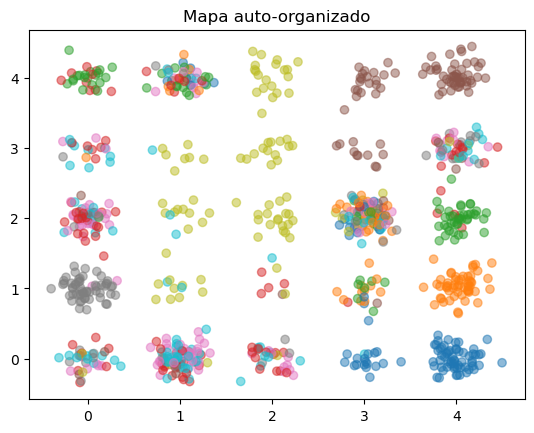

In [106]:
model7 = SOM(featureCount = data.shape[1], mapSize = 5, seed = 207)

model7.train(
    X = data,
    lr_start = 0.41,
    lr_decay = 0.008866389842496561,
    ir_start = 2,
    ir_decay = 0.0027725887222397813,
    epochs = 1000
)

model7.plotScatter(data, labels)

Para 6x6

Epoch 0 of 1000
Epoch 100 of 1000
Epoch 200 of 1000
Epoch 300 of 1000
Epoch 400 of 1000
Epoch 500 of 1000
Epoch 600 of 1000
Epoch 700 of 1000
Epoch 800 of 1000
Epoch 900 of 1000


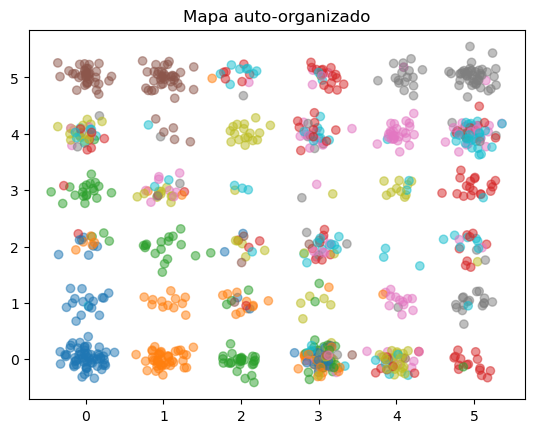

In [107]:
model8 = SOM(featureCount = data.shape[1], mapSize = 6, seed = 207)

model8.train(
    X = data,
    lr_start = 0.022000000000000002,
    lr_decay = 0.0029632090818484313,
    ir_start = 5,
    ir_decay = 0.004605170185988092,
    epochs = 1000
)

model8.plotScatter(data, labels)

Epoch 0 of 1000
Epoch 100 of 1000
Epoch 200 of 1000
Epoch 300 of 1000
Epoch 400 of 1000
Epoch 500 of 1000
Epoch 600 of 1000
Epoch 700 of 1000
Epoch 800 of 1000
Epoch 900 of 1000


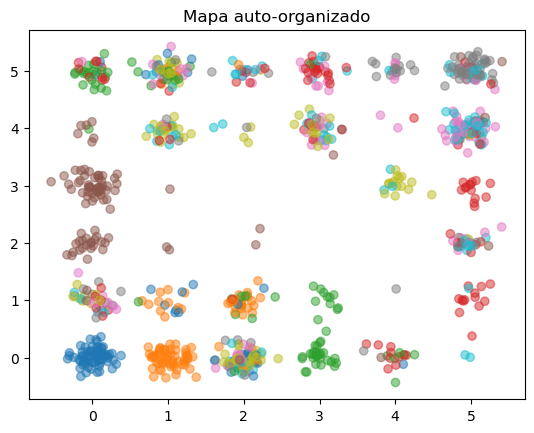

In [108]:
model9 = SOM(featureCount = data.shape[1], mapSize = 6, seed = 207)

model9.train(
    X = data,
    lr_start = 0.019,
    lr_decay = 0.007275172319452771,
    ir_start = 4,
    ir_decay = 0.004158883083359671,
    epochs = 1000
)

model9.plotScatter(data, labels)

Epoch 0 of 1000
Epoch 100 of 1000
Epoch 200 of 1000
Epoch 300 of 1000
Epoch 400 of 1000
Epoch 500 of 1000
Epoch 600 of 1000
Epoch 700 of 1000
Epoch 800 of 1000
Epoch 900 of 1000


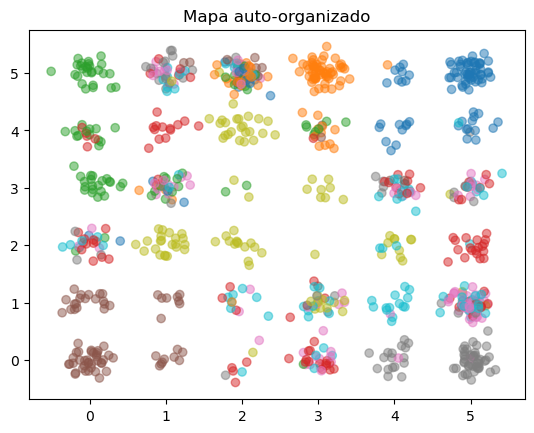

In [109]:
model10 = SOM(featureCount = data.shape[1], mapSize = 6, seed = 207)

model10.train(
    X = data,
    lr_start = 1.7800000000000007,
    lr_decay = 0.01174986146170406,
    ir_start = 2,
    ir_decay = 0.0027725887222397813,
    epochs = 1000
)

model10.plotScatter(data, labels)

In [110]:
model11 = SOM(featureCount = data.shape[1], mapSize = 6, seed = 207)

model11.train(
    X = data,
    lr_start = 0.022000000000000002,
    lr_decay = 0.0029632090818484313,
    ir_start = 5,
    ir_decay = 0.004605170185988092,
    epochs = 1000
)

model11.plotScatter(data, labels)

Epoch 0 of 1000
Epoch 100 of 1000
Epoch 200 of 1000
Epoch 300 of 1000
Epoch 400 of 1000
Epoch 500 of 1000


KeyboardInterrupt: 

En conclusión **no pareciera haber una mejora significativa al utilizar los hiperparámetros buscados automáticamente contra los que se buscan a ojo**. Esto puede deberse a los siguientes motivos:

En primer lugar puede ser que encontrar una función de costo que sea represetativa del error cometido al entrenar sea mucho más complejo de lo que pensabamos y si bien esta función se aproxima en cierta medida aún difiere mucho del error real. Por ejemplo podría pasar que estén mal ponderados los términos y por lo tanto siempre es muhco más importante el error de no dejar celdas vacías o muy llenas y no penaliza tan duramente como debería que haya mucha mezcla de clases en una misma unidad.

Por otro lado podría pasar que no mejore mucho más que lo que vimos hasta ahora y que con una mezcla de buena intuición, los gráficos de las funciones de `lr_st` y `lr_dr` y un factor también de suerte, hayamos encontrado buenos hiperparámetros a ojo que sean masomenos representativos de los mejores modelos a los que se podría llegar.